In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.positional_arxiv import load_data, get_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.gamma import GammaGraphSage

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
data = load_data()

data, edges_val, edges_test, neg_edges_val, neg_edges_test =\
    get_val_test_edges(data, remove_from_data=True, device=device)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

## Training

In [7]:
for run in range(30):
    gamma = GammaGraphSage(device, data.num_nodes, run=run)
    torch.cuda.empty_cache()
    gamma.train(edge_index,
                edges_val,
                edges_test,
                neg_edges_val,
                neg_edges_test,
                data.adj_t,
                data.y)

2022-05-24 22:41:53 - INFO : Run: 0000, Epoch: 0001, Train Loss: 1.3988, Valid loss: 1.1481, Test loss: 1.1483, Train AUC: 0.5862, Valid AUC: 0.5845, Test AUC: 0.5808
2022-05-24 22:42:00 - INFO : Run: 0000, Epoch: 0002, Train Loss: 1.0873, Valid loss: 1.0908, Test loss: 1.0913, Train AUC: 0.6110, Valid AUC: 0.6053, Test AUC: 0.6009
2022-05-24 22:42:06 - INFO : Run: 0000, Epoch: 0003, Train Loss: 1.0459, Valid loss: 1.0593, Test loss: 1.0599, Train AUC: 0.6284, Valid AUC: 0.6205, Test AUC: 0.6158
2022-05-24 22:42:13 - INFO : Run: 0000, Epoch: 0004, Train Loss: 1.0140, Valid loss: 1.0312, Test loss: 1.0320, Train AUC: 0.6437, Valid AUC: 0.6352, Test AUC: 0.6291
2022-05-24 22:42:19 - INFO : Run: 0000, Epoch: 0005, Train Loss: 0.9838, Valid loss: 1.0034, Test loss: 1.0046, Train AUC: 0.6517, Valid AUC: 0.6421, Test AUC: 0.6364
2022-05-24 22:42:26 - INFO : Run: 0000, Epoch: 0006, Train Loss: 0.9549, Valid loss: 0.9769, Test loss: 0.9786, Train AUC: 0.6573, Valid AUC: 0.6463, Test AUC: 0.640

## Results

In [6]:
metrics = GammaGraphSage.read_metrics()
print(metrics.shape)
metrics.head()

(1561, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,None,1.626176,1.626176,0.510545,0.509700,0.513489
1,0,1,1.397614447319292,1.143581,1.147128,0.574381,0.574979,0.571039
2,0,2,1.0872652628378756,1.091411,1.093326,0.598073,0.594066,0.589763
3,0,3,1.0472264311974404,1.059901,1.062071,0.617314,0.611050,0.607273
4,0,4,1.014795686326906,1.031613,1.032941,0.637873,0.629772,0.623901


### Sumarize metrics per epoch

In [7]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [8]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [9]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,-1.000000,0.000000,1.626148,0.000036,1.626148,0.000036,0.507734,0.002148,0.506904,0.004299,0.507046,0.004151
1,1.395531,0.010331,1.158063,0.010953,1.159348,0.010691,0.608939,0.016808,0.605424,0.015498,0.599845,0.015000
2,1.090491,0.004075,1.090804,0.002964,1.093870,0.002942,0.627109,0.011623,0.621347,0.010678,0.615044,0.009923
3,1.044141,0.002447,1.056563,0.002607,1.059401,0.002682,0.635499,0.007653,0.627746,0.007031,0.621922,0.006344
4,1.011187,0.002231,1.027566,0.002708,1.030021,0.002645,0.644629,0.005772,0.635333,0.005566,0.629702,0.005176


In [10]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
17,0.707369,0.002085,0.754574,0.001939,0.756080,0.002015,0.679326,0.000940,0.669516,0.001114,0.663159,0.001138
16,0.724772,0.002098,0.769837,0.002044,0.771345,0.002120,0.679504,0.000873,0.669472,0.001049,0.663150,0.001093
15,0.742850,0.002189,0.785792,0.002171,0.787329,0.002245,0.679534,0.000928,0.669325,0.001135,0.662710,0.001049
18,0.690654,0.002122,0.739984,0.001958,0.741452,0.001999,0.678899,0.000766,0.669319,0.001054,0.662940,0.001141
19,0.674590,0.002158,0.726082,0.002011,0.727487,0.002045,0.678496,0.001020,0.669203,0.001145,0.662745,0.001247


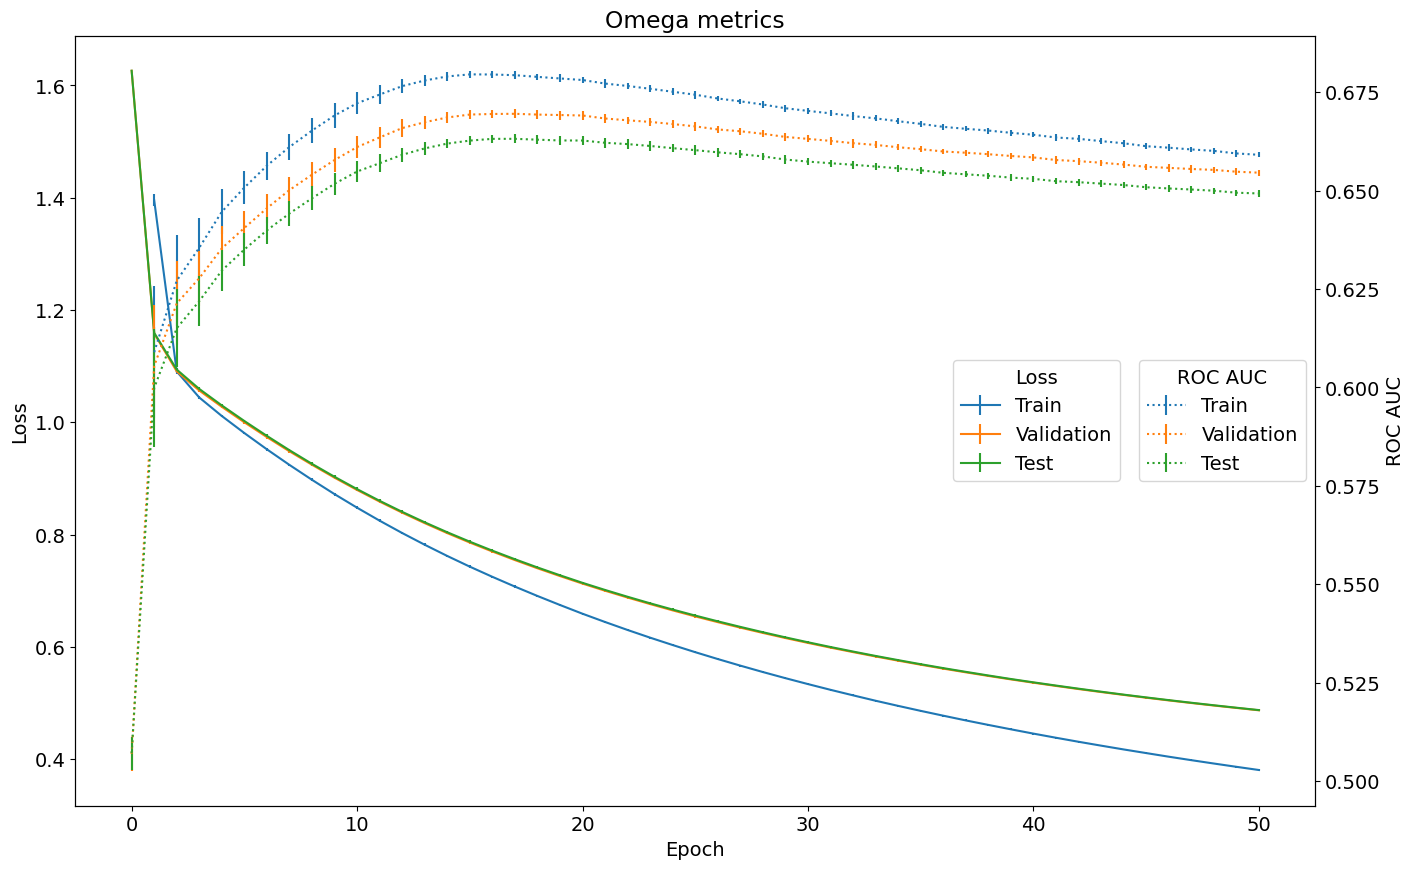

In [11]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig('reports/images/omega_training_metrics.pdf')

## Score Best model

In [12]:
best_model_metrics = metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run           10.000000
epoch         19.000000
loss_train     0.673830
loss_val       0.725239
loss_test      0.726481
auc_train      0.680729
auc_val        0.672154
auc_test       0.665832
Name: 560, dtype: float64

In [13]:
best_model_metrics.to_json('models/gamma_graph_sage/best_model_info.json')

### Load data

In [15]:
data = load_data()

data = prepare_adjencency(data, to_symmetric=True).to(device)

all_edges = get_edge_index_from_adjencency(data, device)

In [22]:
data.adj_t

SparseTensor(row=tensor([     0,      0,      0,  ..., 169341, 169342, 169342], device='cuda:0'),
             col=tensor([   411,    640,   1162,  ..., 163274,  27824, 158981], device='cuda:0'),
             size=(169343, 169343), nnz=2315598, density=0.01%)

### Load model

In [16]:
gamma = GammaGraphSage.load_model(
    int(best_model_metrics['run']),
    int(best_model_metrics['epoch']),
    device,
    data.num_nodes)

### Score model

In [17]:
preds = gamma.forward(all_edges, data.adj_t).to('cpu').detach().numpy()
preds[:5]

array([[0.64966935],
       [0.78425   ],
       [0.78780687],
       [0.78720075],
       [0.7848394 ]], dtype=float32)

In [18]:
theta = gamma.is_same_class(all_edges, data.y).to('cpu').detach().numpy()

In [19]:
roc_auc_score(theta, preds)

0.6808699849370341

In [21]:
theta.mean()

0.6542197738985782

### Save output

In [21]:
cpu_edges = all_edges.to('cpu').numpy()
edges_gamma_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'gamma_pred': preds[:,0]
})
print(edges_gamma_df.shape)
edges_gamma_df.head()

(2315598, 3)


,source,target,gamma_pred
0,411,0,0.649669
1,640,0,0.784250
2,1162,0,0.787807
3,1897,0,0.787201
4,3396,0,0.784839


In [36]:
edges_gamma_df.to_csv('data/gamma_graph_sage/01-1_gamma_scored_edges.csv', index=False)

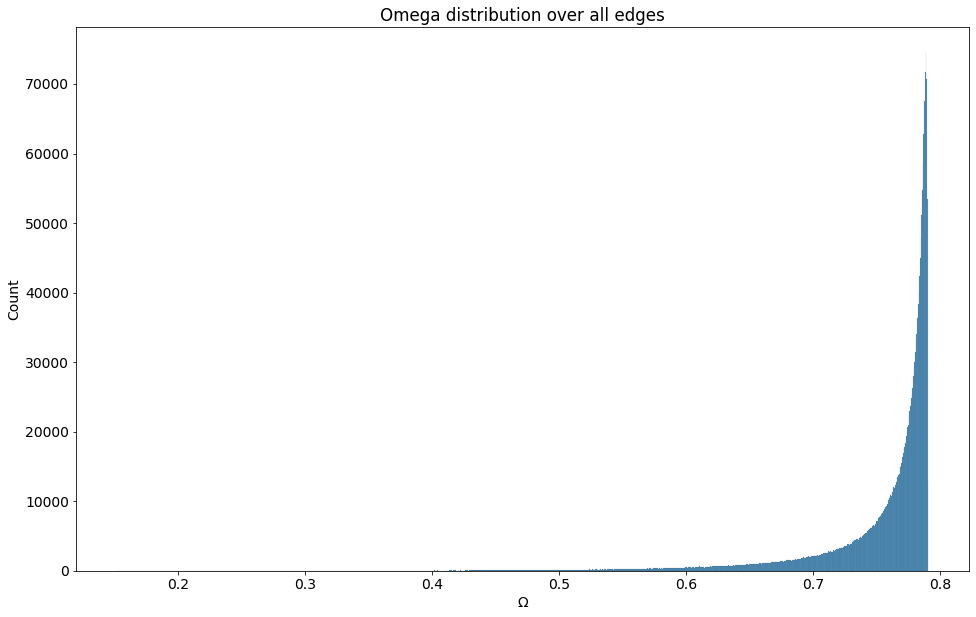

In [51]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_gamma_df['gamma_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
plt.savefig('reports/images/best_omega_distribution.png')

In [44]:
metrics = {
    'ROC AUC - All edges': [roc_auc_score(theta, preds)],
    'Mean': [edges_gamma_df['gamma_pred'].mean()],
    'Std. Dev.': [edges_gamma_df['gamma_pred'].std()],
    'Skewness': [edges_gamma_df['gamma_pred'].skew()],
    'Kurtosis': [edges_gamma_df['gamma_pred'].kurt()],
}

print(pd.DataFrame(metrics).round(3).style.to_latex())

\begin{tabular}{lrrrrr}
 & ROC AUC - All edges & Mean & Std. Dev. & Skewness & Kurtosis \\
0 & 0.681000 & 0.755000 & 0.054000 & -3.134000 & 13.155000 \\
\end{tabular}



In [ ]:
edges_gamma_df[